In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

________________________________

In [118]:
network = 'tarbase'
ppi = 'preppi'
target_homology = 'wgd' #'wgd', 'ssd' or 'mix'
remove_pre_2R = True

In [134]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi}.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.{ppi}.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.{ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi}.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi}.tsv'
else:
	raise ValueError("target_homology must be 'wdg', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [120]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [121]:
df_wgd = df_1
df_ssd = df_2

In [122]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [123]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

if remove_pre_2R:
	df_ssd = df_ssd[~(df_ssd["miRNA_1"].apply(all_clades_in_pre2R) & df_ssd["miRNA_2"].apply(all_clades_in_pre2R))]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  113
Number of SSD pairs:  417


In [124]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [125]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  113
Number of SSD pairs after removing miRNA pairs from SSD:  402


In [126]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [127]:
df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [128]:
df_wgd_nbifan = df_wgd['n_relevant_bifan'].astype(int)
df_ssd_nbifan = df_ssd['n_relevant_bifan'].astype(int)

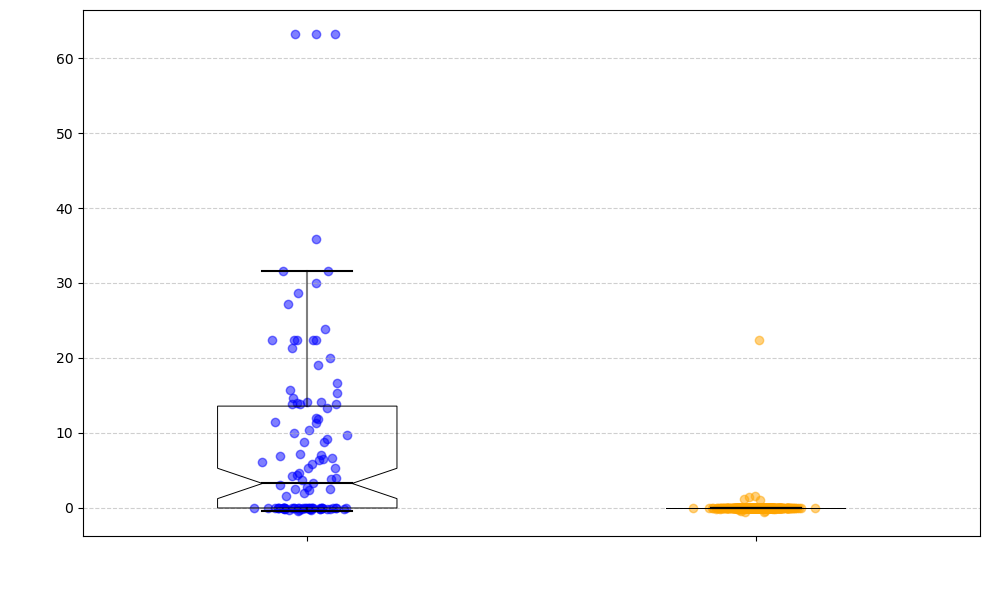

Number of WGD pairs:  111
Number of SSD pairs:  402


In [129]:
# Sample sizes
n_wgd = len(df_wgd_zscores)
n_ssd = len(df_ssd_zscores)

# Jittered x positions
x_wgd = np.random.normal(0, 0.04, size=n_wgd)
x_ssd = np.random.normal(1, 0.04, size=n_ssd)

plt.figure(figsize=(10, 6))

# Boxplot with transparent fill and notches
box = plt.boxplot(
    [df_wgd_zscores, df_ssd_zscores],
    positions=[0, 1],
    widths=0.4,
    notch=True,
    patch_artist=True,
    showfliers=False
)

# Make boxes transparent
for patch in box['boxes']:
	patch.set_facecolor('none')
	patch.set_edgecolor('black')
	patch.set_linewidth(0.7)

# Customize other boxplot parts
for element in ['medians', 'whiskers', 'caps']:
    for line in box[element]:
        line.set_color('black')
        line.set_linewidth(1.5)
        # width of the whiskers
        if element == 'whiskers':
            line.set_alpha(0.5)

# Jittered dots
plt.scatter(x_wgd, df_wgd_zscores, alpha=0.5, color='blue', label='WGD')
plt.scatter(x_ssd, df_ssd_zscores, alpha=0.5, color='orange', label='SSD')

# Labels
plt.xticks([0, 1], [f' ', f' '], fontsize=25)
plt.ylabel(' ', fontsize=30)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

In [130]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS test results with parameters:\nnetwork={network}\nppi={ppi}\ntarget_homology={target_homology}\nremove_pre_2R={remove_pre_2R}")
print(100 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
ppi=preppi
target_homology=wgd
remove_pre_2R=True
KS statistic: 0.5625924431894581, p-value: 4.209863129394027e-26


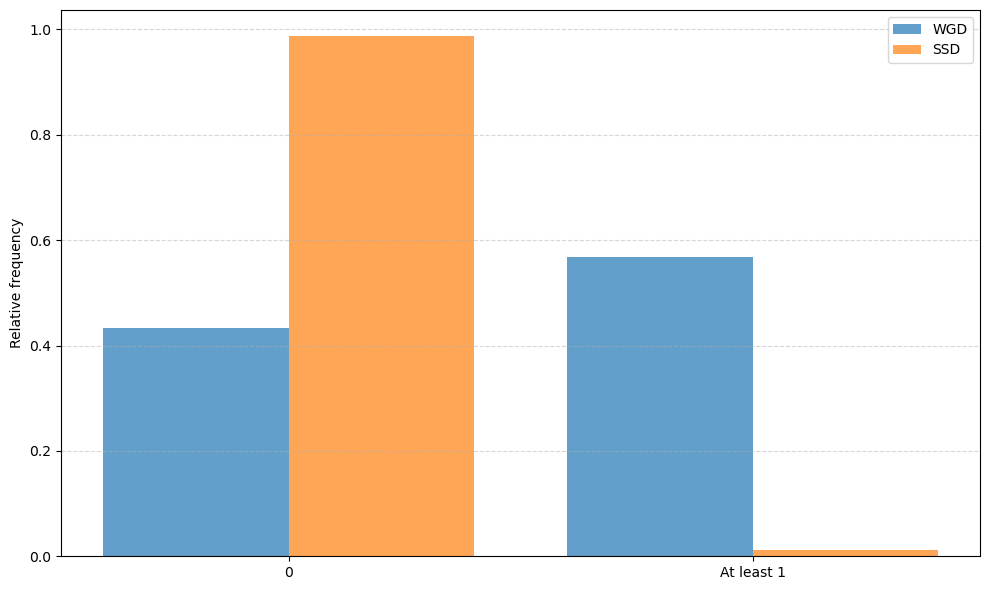

WGD pairs with 0 relevant bifan:  48
SSD pairs with 0 relevant bifan:  397
WGD pairs with at least 1 relevant bifan:  63
SSD pairs with at least 1 relevant bifan:  5


In [131]:
def bin_bifans(count):
    if count == 0:
        return '0'
    else:
        return 'At least 1'

# Bin the counts
wgd_binned = pd.Series(df_wgd_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(['0', 'At least 1'], fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(['0', 'At least 1'], fill_value=0)

# Plot
labels = ['0', 'At least 1']
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels)
plt.xlabel('')
plt.ylabel('Relative frequency')
plt.title('')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("WGD pairs with 0 relevant bifan: ", len(df_wgd[df_wgd['n_relevant_bifan'] == 0]))
print("SSD pairs with 0 relevant bifan: ", len(df_ssd[df_ssd['n_relevant_bifan'] == 0]))
print("WGD pairs with at least 1 relevant bifan: ", len(df_wgd[df_wgd['n_relevant_bifan'] > 0]))
print("SSD pairs with at least 1 relevant bifan: ", len(df_ssd[df_ssd['n_relevant_bifan'] > 0]))

In [132]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1077,MIR15A,MIR16-1,478,1213,393,0.239,0.471040,1,220,1.6155728897250137,0.024392960740239666
1078,MIR15A,MIR16-2,478,1315,396,0.278,0.526038,1,244,1.3725243624486116,0.03217466210467923
1092,MIR16-1,MIR497,1213,539,270,0.306,0.588527,1,251,1.179215277775851,0.03827907499033323
1096,MIR16-2,MIR497,1315,539,281,0.372,0.601345,1,313,1.0443253609354428,0.054205979256766845
1293,MIR513A1,MIR513A2,232,232,232,0.002,0.044677,1,2,22.338307903688676,0.0


In [133]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000)
1,MIR103A1,MIR103A2,950,1075,950,0.703,0.837133,13,0,14.689429024878699,1.9984014443252818e-15
2,MIR103A1,MIR107,950,959,927,0.626,0.819832,12,0,13.873579343331992,9.103828801926284e-15
3,MIR103A2,MIR107,1075,959,930,0.704,0.846395,12,0,13.346019188062533,4.374278717023117e-14
4,MIR106A,MIR106B,538,398,205,0.035,0.183780,1,35,5.250850271282601,2.477684724055962e-12
5,MIR106A,MIR17,538,1373,308,0.378,0.609193,3,5,4.304055353552772,4.7000632797722375e-05
8,MIR124-1,MIR124-3,170,170,170,0.001,0.031607,2,0,63.24556111697485,0.0
9,MIR124-1,MIR124-2,170,170,170,0.001,0.031607,2,0,63.24556111697485,0.0
10,MIR124-3,MIR124-2,170,170,170,0.001,0.031607,2,0,63.24556111697485,0.0
14,MIR128-1,MIR128-2,207,207,207,0.002,0.044677,1,2,22.338307903688676,0.0
19,MIR133A1,MIR133A2,119,119,119,0.001,0.031607,1,1,31.606961258558215,0.0
